In [6]:
!pip install dlib
!pip install mtcnn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.9 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.5 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 KB 21.6 MB/s eta 0:00:00


In [ ]:
!pip install 

In [3]:
import cv2
import os
import numpy as np
#from google.colab.patches import cv2_imshow
import time
import os
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
import random
random.seed(99)

In [6]:
path0, = !echo $PWD
print(path0)
path0 = path0 + '/ComputerVisionDQuispe/models/'
modelFile = f'{path0}/res10_300x300_ssd_iter_140000.caffemodel'
configFile = f'{path0}/deploy.prototxt'
mname = "DNN"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
detector_mtcnn = MTCNN()

/home/aldo/maestria/dist_comp_vision


W0000 00:00:1768249910.362513 1932833 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
os.path.isfile( "/home/aldo/maestria/dist_comp_vision//ComputerVisionDQuispe/models//deploy.prototxt")

True

In [8]:
# wider face dataset
# https://drive.google.com/file/d/1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T/view

In [10]:
rootpath = "/home/aldo/maestria/dist_comp_vision/"#os.listdir("/home/aldo/maestria/dist_comp_vision/LFW/lfw-deepfunneled/lfw-deepfunneled/")

In [11]:
val_bbox_path = f"{rootpath}/WFD/wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt"
val_images = f"{rootpath}/WFD/wider_val/WIDER_val/images/"


def parse_wider_annotations(annotation_file):
    """
    Returns structure: { 'image_name.jpg': [[x, y, w, h], [x, y, w, h], ...] }
    """
    wider_data = {}
    
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
        
    i = 0
    while i < len(lines):
        filename = lines[i].strip() # filename
        i += 1
        
        try:
            num_faces = int(lines[i].strip()) # numer of faces
            i += 1
        except ValueError:
            
            break
            
        faces = []
        if num_faces == 0:
            # in case number of faces = 0 
            wider_data[filename] = []
            continue

        for _ in range(num_faces):
            # feature line: x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose
            # (x, y, w, h)
            line_data = lines[i].strip().split()
            x = int(line_data[0])
            y = int(line_data[1])
            w = int(line_data[2])
            h = int(line_data[3])
            
            # (x, y, w, h)
            faces.append([x, y, w, h])
            i += 1
            
        wider_data[filename] = faces
        
    return wider_data

In [72]:
img_bgr.shape

(694, 1024, 3)

In [12]:
# randomize images
ground_truth = parse_wider_annotations(val_bbox_path)

rnd_keys = list(ground_truth.keys())
random.shuffle(rnd_keys)
ground_truth = {k:ground_truth[k] for k in rnd_keys}

confidenceThreshold = 0.5
print(f"Etiquetas cargadas para {len(ground_truth)} imágenes.")

Etiquetas cargadas para 3226 imágenes.


## Dummie model test: DNN & MTCNN

    DNN 1
    MTCNN 1
		 0.9822607636451721


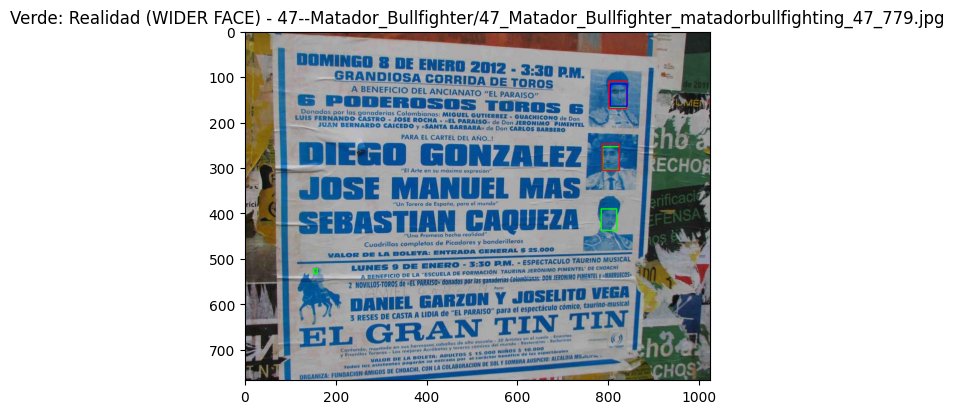

    DNN 1
    MTCNN 1
		 0.9998815059661865


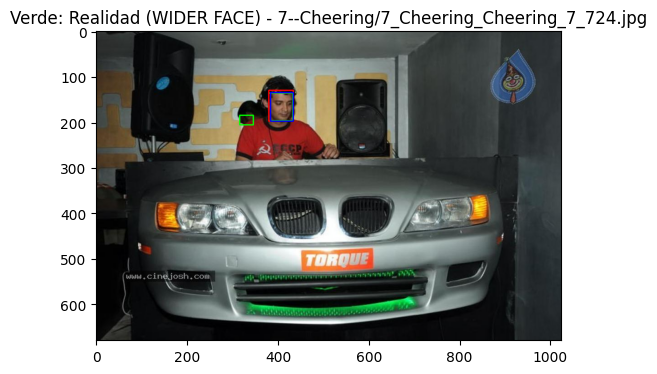

    DNN 1
    MTCNN 2
		 0.9968518614768982
		 0.9711928963661194


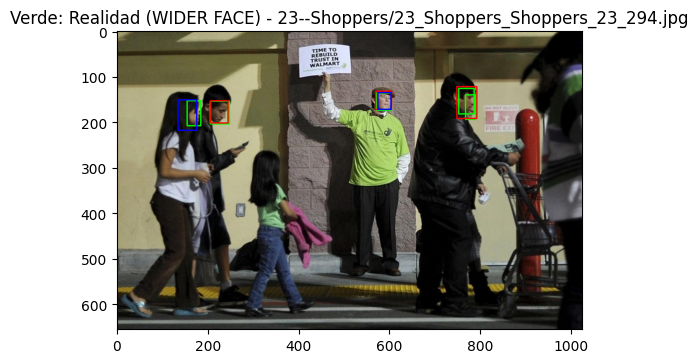

    DNN 1
    MTCNN 1
		 0.9933627843856812


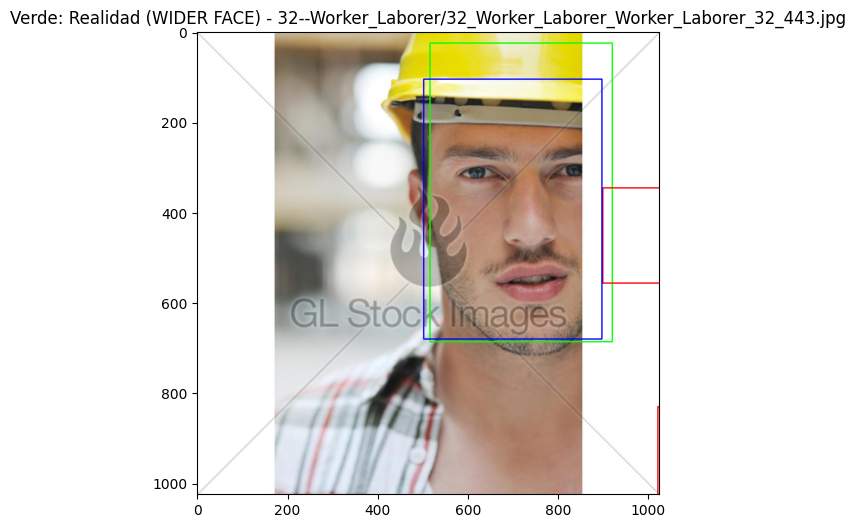

    DNN 1
    MTCNN 3
		 1.0
		 0.9999995231628418
		 0.9999642372131348


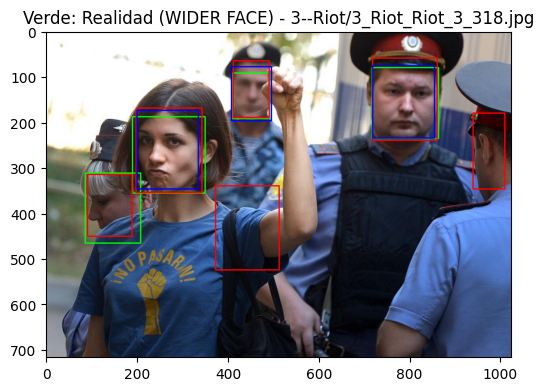

In [13]:
# iterate on images to test the model
count = 0
for img_path_rel, true_boxes in ground_truth.items():
    if count > 4: break # Solo probamos 3 para no saturar la salida
    
    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    img = img_bgr.copy()
    height_, width_ = img.shape[:2]
    if img_bgr is None:
        print(f"No se encontró: {full_path}")
        continue

    for box in true_boxes:
        x, y, w, h = box
        cv2.rectangle(img_bgr, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # --- applying models --- CNN & MTCNN
    # --- DNN
    
    #blob = cv2.dnn.blobFromImage(img_rgb, 1.0, (300,300), (104.0, 177.0, 123.0))
    blob = cv2.dnn.blobFromImage(img, 1.0, (width_, height_), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    detections = net.forward()
    print("    DNN", len(detections))
    detected_faces_count = 0
    for i in range(detections.shape[2]):
      confidence = detections[0, 0, i, 2] ## el tercer indice es el valor de confianza

      if confidence > confidenceThreshold:
        detected_faces_count += 1
        #counts += 1
        box_normalized = detections[0,0,i,3:7]
        box = box_normalized * np.array([width_, height_, width_, height_])
        (x, y, x1, y1) = box.astype('int')

        ## DIBUJA EL RECTANGULO
        cv2.rectangle(img_bgr, (x, y), (x1, y1), (0, 0, 255), 2)

    # --- MTCNN
    #img_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    result =  detector_mtcnn.detect_faces(img_rgb)
    print("    MTCNN", len(result))
    rectangles = []
    

    for face in result:
        confianza = face['confidence']
        print("\t\t", confianza)
        # filter by confidence
        if confianza > 0.50: 
            x, y, width, height = face['box']
            
            # avoid negative coord.
            x = max(0, x)
            y = max(0, y)
            x1 = x + width
            y1 = y + height
            cv2.rectangle(img_bgr, (x, y), (x1, y1), (255, 0, 0), 2)
            rectangles.append((x, y, x1, y1))
    
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Verde: Realidad (WIDER FACE) - {img_path_rel}")
    plt.show()
    
    count += 1

## First Analysis

In [14]:

def bb_intersection_over_union(boxA, boxB):
    # overlapping area coordenates
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # overlapping area
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # detected areas
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def calculate_image_stats(pred_boxes, gt_boxes, iou_thresh=0.5):
    """
    for a single image
    Compares and returns : True Positives, False Positives, False Negatives
    """
    tp = 0
    fp = 0
    fn = 0


    gt_pendientes = list(gt_boxes) 
    preds_pendientes = list(pred_boxes)
    
    # greedy matcher
    for pred in preds_pendientes:
        best_iou = 0
        best_gt_idx = -1
        
        for i, gt in enumerate(gt_pendientes):
            iou = bb_intersection_over_union(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i
        
        # evaluat overlapping percent - > if true TP
        if best_iou >= iou_thresh:
            tp += 1
            # remove GT from list
            gt_pendientes.pop(best_gt_idx)
        else:
            # False Positive
            fp += 1
            
    # remanent GTare FN false negatives
    fn = len(gt_pendientes)
    
    return tp, fp, fn
    

In [15]:

CONF_THRESH_DNN = 0.5   # DNN confidence threshold
CONF_THRESH_MTCNN = 0.8 # Confidence threshold MTCNN
IOU_THRESH = 0.3      # overlapping threshold

# counter
stats = {
    'DNN':   {'TP': 0, 'FP': 0, 'FN': 0, 'TotalTime':.0},
    'MTCNN': {'TP': 0, 'FP': 0, 'FN': 0, 'TotalTime':.0}
}

print("Iniciando evaluación... ")

count = 0
limit = 50 # limiten number of images / None: allows all images

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    #if count % 10 == 0: 
    #print(f"Procesando imagen {count}...", end="\r")
    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    height_, width_ = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Convertir Ground Truth a formato [x1, y1, x2, y2] para facilitar IoU
    gt_boxes = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])

    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (width_, height_), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    
    # --- DNN
    start_time = time.perf_counter() # Inicio cronómetro preciso
    detections = net.forward()
    end_time = time.perf_counter()   # Fin cronómetro
    
    stats['DNN']['TotalTime'] += (end_time - start_time) # Acumulamos la diferencia
    
    dnn_boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > CONF_THRESH_DNN:
            box = detections[0, 0, i, 3:7] * np.array([width_, height_, width_, height_])
            (x1, y1, x2, y2) = box.astype("int")
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(width_, x2), min(height_, y2)
            if x2 > x1 and y2 > y1:
                dnn_boxes.append([x1, y1, x2, y2])

    tp, fp, fn = calculate_image_stats(dnn_boxes, gt_boxes, IOU_THRESH)
    stats['DNN']['TP'] += tp
    stats['DNN']['FP'] += fp
    stats['DNN']['FN'] += fn


    # --- EVALUAR MTCNN (+ Tiempo)

    start_time = time.perf_counter()
    result = detector_mtcnn.detect_faces(img_rgb)
    end_time = time.perf_counter()
    
    stats['MTCNN']['TotalTime'] += (end_time - start_time)

    mtcnn_boxes = []
    for face in result:
        if face['confidence'] > CONF_THRESH_MTCNN:
            x, y, w, h = face['box']
            x1, y1 = max(0, x), max(0, y)
            x2, y2 = x1 + w, y1 + h
            mtcnn_boxes.append([x1, y1, x2, y2])

    tp, fp, fn = calculate_image_stats(mtcnn_boxes, gt_boxes, IOU_THRESH)
    stats['MTCNN']['TP'] += tp
    stats['MTCNN']['FP'] += fp
    stats['MTCNN']['FN'] += fn
print()
print("Evaluación completada.")

Iniciando evaluación... 

Evaluación completada.


In [16]:
def print_report(nombre, datos, total_imagenes):
    tp = datos['TP']
    fp = datos['FP']
    fn = datos['FN']
    total_time = datos['TotalTime']
    
    # precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Time
    avg_time = total_time / total_imagenes if total_imagenes > 0 else 0
    fps = 1.0 / avg_time if avg_time > 0 else 0
    
    print('')
    print(f"=========================================")
    print(f" REPORT: {nombre}")
    print(f"=========================================")
    print(f"--- RENDIMIENTO ---")
    print(f" PRECISION:  {precision:.4f} (Calidad)")
    print(f" RECALL:     {recall:.4f} (Cobertura)")
    print(f" F1-SCORE:   {f1_score:.4f}")
    print(f" TP: {tp} | FP: {fp} | FN: {fn}")
    print(f"--- VELOCIDAD ---")
    print(f" Tiempo Total:   {total_time:.2f} seg")
    print(f" Latencia Prom:  {avg_time*1000:.1f} ms/img")
    print(f" FPS Estimados:  {fps:.2f} FPS")
    print(f"\n")


print(f"\nEvaluación finalizada sobre {count} imágenes.\n")



Evaluación finalizada sobre 50 imágenes.



In [17]:
print_report("OpenCV DNN", stats['DNN'], count)
print_report("MTCNN", stats['MTCNN'], count)



 REPORT: OpenCV DNN
--- RENDIMIENTO ---
 PRECISION:  0.8165 (Calidad)
 RECALL:     0.3342 (Cobertura)
 F1-SCORE:   0.4743
 TP: 129 | FP: 29 | FN: 257
--- VELOCIDAD ---
 Tiempo Total:   4.31 seg
 Latencia Prom:  86.2 ms/img
 FPS Estimados:  11.61 FPS



 REPORT: MTCNN
--- RENDIMIENTO ---
 PRECISION:  0.9270 (Calidad)
 RECALL:     0.4275 (Cobertura)
 F1-SCORE:   0.5851
 TP: 165 | FP: 13 | FN: 221
--- VELOCIDAD ---
 Tiempo Total:   24.08 seg
 Latencia Prom:  481.7 ms/img
 FPS Estimados:  2.08 FPS




In [18]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

### General simple metrics


Generando Reportes Gráficos...


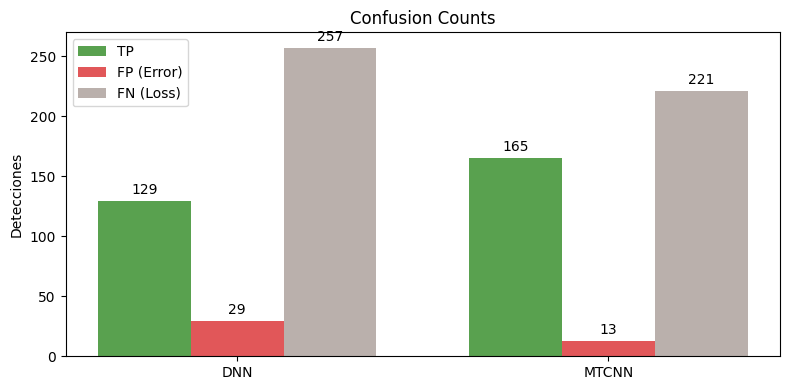

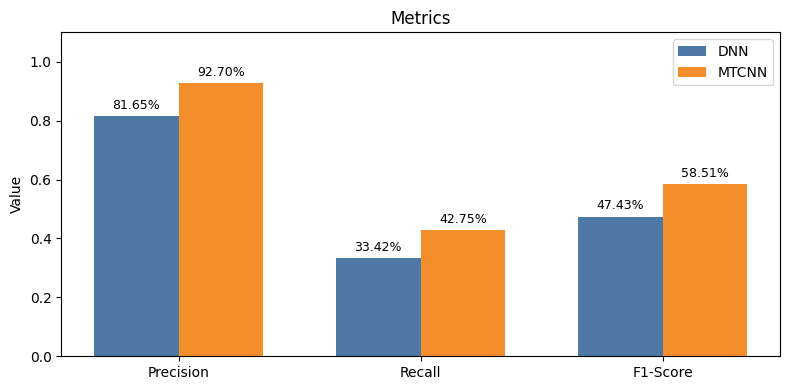

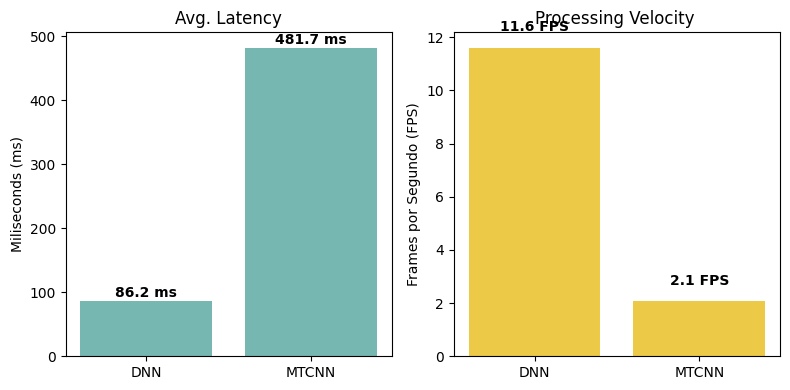

In [19]:
def graphic_report(stats, total_images):
    
    modelos = list(stats.keys()) # ['DNN', 'MTCNN']
    
    
    tp = [stats[m]['TP'] for m in modelos]
    fp = [stats[m]['FP'] for m in modelos]
    fn = [stats[m]['FN'] for m in modelos]
    times = [stats[m]['TotalTime'] for m in modelos]
    
    precision = []
    recall = []
    f1 = []
    fps = []
    latency = []

    for m in modelos:
        t, f_p, f_n = stats[m]['TP'], stats[m]['FP'], stats[m]['FN']
        total_time = stats[m]['TotalTime']
    
        p = t / (t + f_p) if (t + f_p) > 0 else 0
        r = t / (t + f_n) if (t + f_n) > 0 else 0
        f = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
        
        precision.append(p)
        recall.append(r)
        f1.append(f)
    
        avg_time = total_time / total_images if total_images > 0 else 0
        latency.append(avg_time * 1000) # a ms
        fps.append(1.0 / avg_time if avg_time > 0 else 0)

    
    #plt.style.use('ggplot') 
    #'seaborn-v0_8-colorblind')
    colores = ['#4E79A7', '#F28E2B'] 
    
    # confusion matrix
    fig1, ax1 = plt.subplots(figsize=(8, 4), facecolor="none")
    x = np.arange(len(modelos))
    width = 0.25
    
    rects1 = ax1.bar(x - width, tp, width, label='TP ', color='#59a14f') # Verde
    rects2 = ax1.bar(x, fp, width, label='FP (Error)', color='#e15759')      # Rojo
    rects3 = ax1.bar(x + width, fn, width, label='FN (Loss)', color='#bab0ac')  # Gris

    ax1.set_ylabel('Detecciones')
    ax1.set_title('Confusion Counts')
    ax1.set_xticks(x)
    ax1.set_xticklabels(modelos)
    ax1.legend()

    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax1.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.tight_layout()
    plt.show()

    # metrics
    fig2, ax2 = plt.subplots(figsize=(8, 4), facecolor="none")
    x = np.arange(3)  # Precision, Recall, F1
    width = 0.35
    
    # dnn data
    vals_m1 = [precision[0], recall[0], f1[0]]
    # MTCNN data
    vals_m2 = [precision[1], recall[1], f1[1]]

    rects1 = ax2.bar(x - width/2, vals_m1, width, label=modelos[0], color=colores[0])
    rects2 = ax2.bar(x + width/2, vals_m2, width, label=modelos[1], color=colores[1])

    ax2.set_ylabel('Value')
    ax2.set_title('Metrics')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
    ax2.set_ylim(0, 1.1) 
    ax2.legend()

    def autolabel_percent(rects):
        for rect in rects:
            height = rect.get_height()
            ax2.annotate(f'{height:.2%}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel_percent(rects1)
    autolabel_percent(rects2)
    plt.tight_layout()
    plt.show()

    # time and velocity
    fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(8, 4), facecolor="none")
    #plt.figure(facecolor='yellow')
    
    # Subplot latency
    ax3a.bar(modelos, latency, color=['#76b7b2', '#76b7b2'])
    ax3a.set_title('Avg. Latency')
    ax3a.set_ylabel('Miliseconds (ms)')
    for i, v in enumerate(latency):
        ax3a.text(i, v + 1, f"{v:.1f} ms", ha='center', va='bottom', fontweight='bold')

    # Subplot FPS (Más es mejor)
    ax3b.bar(modelos, fps, color=['#edc948', '#edc948'])
    ax3b.set_title('Processing Velocity ')
    ax3b.set_ylabel('Frames por Segundo (FPS)')
    for i, v in enumerate(fps):
        ax3b.text(i, v + 0.5, f"{v:.1f} FPS", ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- LLAMADA FINAL ---
# Solo tienes que agregar esta línea al final de tu script anterior
# Asegúrate de pasar 'stats' y el contador 'count'
print("\nGenerando Reportes Gráficos...")
graphic_report(stats, count)

### by pixels or face size: 

In [45]:
# Size categories (Height in pixels)
SIZE_RANGES = {
    'Small (<50px)': (0, 50),
    'Medium (50-100px)': (50, 100),
    'Large (>100px)': (100, 9999)
}

# metrics storage: stats[Model][Size][Metric]
stats_size = {
    'DNN':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()},
    'MTCNN': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

def bb_iou_batch(boxA, boxesB):
    """
    Vectorized IoU calculation for one box against a list of boxes.
    """
    if len(boxesB) == 0: return []
    boxesB = np.array(boxesB)
    
    xA = np.maximum(boxA[0], boxesB[:, 0])
    yA = np.maximum(boxA[1], boxesB[:, 1])
    xB = np.minimum(boxA[2], boxesB[:, 2])
    yB = np.minimum(boxA[3], boxesB[:, 3])

    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxesB[:, 2] - boxesB[:, 0] + 1) * (boxesB[:, 3] - boxesB[:, 1] + 1)

    return interArea / (boxAArea + boxBArea - interArea)


def get_size_category(height):
    for name, (min_h, max_h) in SIZE_RANGES.items():
        if min_h <= height < max_h:
            return name
    return 'Large (>100px)'



print("Starting size-based analysis...")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Processing image {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_img, w_img = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    gt_boxes = []
    gt_heights = [] 
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # DNN Prediction
    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_img, h_img), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    detections = net.forward()
    
    dnn_preds = []
    for i in range(detections.shape[2]):
        if detections[0, 0, i, 2] > CONF_THRESH_DNN:
            box = detections[0, 0, i, 3:7] * np.array([w_img, h_img, w_img, h_img])
            dnn_preds.append(box.astype("int"))

    # MTCNN Prediction
    result = detector_mtcnn.detect_faces(img_rgb)
    mtcnn_preds = []
    for face in result:
        if face['confidence'] > CONF_THRESH_MTCNN:
            x, y, w, h = face['box']
            mtcnn_preds.append([x, y, x+w, y+h])

    # Size-based Matching
    def evaluate_model_by_size(model_name, preds, gts, heights, stats_size):
        # stats_size = {}
        for i, gt in enumerate(gts):
            height = heights[i]
            category = get_size_category(height)
            
            max_iou = 0
            if len(preds) > 0:
                ious = bb_iou_batch(gt, preds)
                max_iou = np.max(ious) if len(ious) > 0 else 0
            
            if max_iou >= IOU_THRESH:
                stats_size[model_name][category]['TP'] += 1
            else:
                stats_size[model_name][category]['FN'] += 1
        return stats_size
    stats_size = evaluate_model_by_size('DNN', dnn_preds, gt_boxes, gt_heights, stats_size)
    stats_size = evaluate_model_by_size('MTCNN', mtcnn_preds, gt_boxes, gt_heights, stats_size)

print("Evaluation completed.")


categories = list(SIZE_RANGES.keys())
recall_dnn = []
recall_mtcnn = []

print("\n--- RECALL BY FACE SIZE ---")
for cat in categories:
    # DNN Stats
    tp = stats_size['DNN'][cat]['TP']
    fn = stats_size['DNN'][cat]['FN']
    total = tp + fn
    rec = tp / total if total > 0 else 0
    recall_dnn.append(rec)
    print(f"[DNN]   {cat}: {rec:.2%} ({tp}/{total} detected)")

    # MTCNN Stats
    tp = stats_size['MTCNN'][cat]['TP']
    fn = stats_size['MTCNN'][cat]['FN']
    total = tp + fn
    rec = tp / total if total > 0 else 0
    recall_mtcnn.append(rec)
    print(f"[MTCNN] {cat}: {rec:.2%} ({tp}/{total} detected)")


x = np.arange(len(categories))
width = 0.35

Starting size-based analysis...
Processing image 20...
Processing image 40...
Processing image 60...
Processing image 80...
Processing image 100...
Evaluation completed.

--- RECALL BY FACE SIZE ---
[DNN]   Small (<50px): 18.49% (262/1417 detected)
[MTCNN] Small (<50px): 32.46% (460/1417 detected)
[DNN]   Medium (50-100px): 79.03% (98/124 detected)
[MTCNN] Medium (50-100px): 79.03% (98/124 detected)
[DNN]   Large (>100px): 78.89% (71/90 detected)
[MTCNN] Large (>100px): 81.11% (73/90 detected)


In [44]:
a_ = 3
def ft(b,a):
    a =a**2
    b=0
    return a 
x = ft(3,a_)
print(a_,x)

3 9


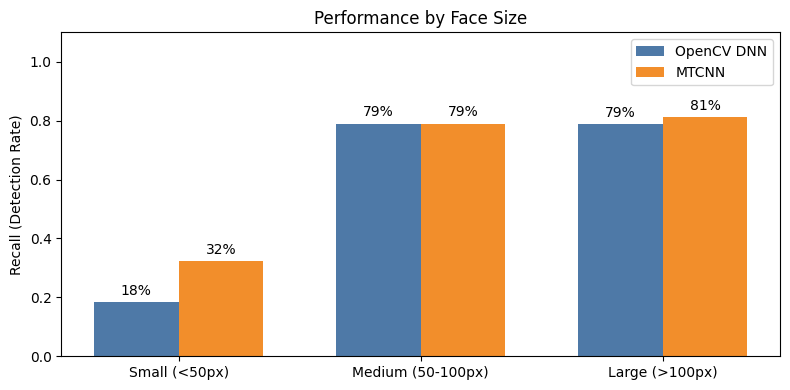

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))
rects1 = ax.bar(x - width/2, recall_dnn, width, label='OpenCV DNN', color='#4E79A7')
rects2 = ax.bar(x + width/2, recall_mtcnn, width, label='MTCNN', color='#F28E2B')

ax.set_ylabel('Recall (Detection Rate)')
ax.set_title('Performance by Face Size')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 1.1)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()

rostros mas grandes son mas detectables, 

Analizando distribución del dataset...
Total de rostros analizados: 39708
Altura mínima: 0 px
Altura máxima: 1224 px
Altura promedio: 37.60 px
Mediana de altura: 20.00 px


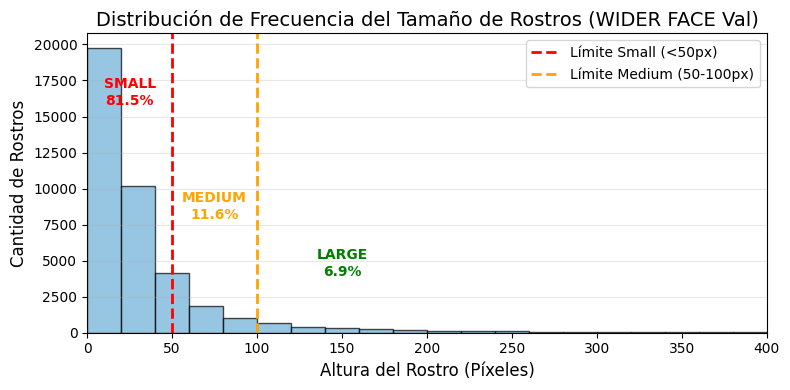

In [24]:

# analisis de alturas de rostros
all_heights = []

print("Analizando distribución del dataset...")
for img_path, boxes in ground_truth.items():
    for box in boxes:
        # box = [x, y, w, h] -> nos interesa el índice 3 (h)
        h = box[3]
        all_heights.append(h)

print(f"Total de rostros analizados: {len(all_heights)}")
print(f"Altura mínima: {min(all_heights)} px")
print(f"Altura máxima: {max(all_heights)} px")
print(f"Altura promedio: {np.mean(all_heights):.2f} px")
print(f"Mediana de altura: {np.median(all_heights):.2f} px")

# 2. Configurar el Histograma
plt.figure(figsize=(8, 4))

# Definimos los bins cada 20 pixeles como pediste
# Limitamos el rango a 400px para que el gráfico no se "aplane" por los outliers gigantes
max_range = 400 
bins = range(0, max_range + 20, 20) 

# Crear histograma
n, bins, patches = plt.hist(all_heights, bins=bins, color='#6baed6', edgecolor='black', alpha=0.7)

# 3. Dibujar las líneas de tus categorías (Small, Medium, Large)
plt.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Límite Small (<50px)')
plt.axvline(x=100, color='orange', linestyle='--', linewidth=2, label='Límite Medium (50-100px)')

# 4. Etiquetas y Estilo
plt.title('Distribución de Frecuencia del Tamaño de Rostros (WIDER FACE Val)', fontsize=14)
plt.xlabel('Altura del Rostro (Píxeles)', fontsize=12)
plt.ylabel('Cantidad de Rostros', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Añadir texto con porcentajes en las zonas
# Calculamos cuántos caen en cada zona para ponerlo en el gráfico
total = len(all_heights)
small = sum(h < 50 for h in all_heights)
medium = sum(50 <= h < 100 for h in all_heights)
large = sum(h >= 100 for h in all_heights) # Incluye los mayores a 400 que no salen en el plot

# Mostrar los porcentajes en el gráfico
plt.text(25, max(n)*0.8, f"SMALL\n{small/total:.1%}", ha='center', color='red', fontweight='bold')
plt.text(75, max(n)*0.4, f"MEDIUM\n{medium/total:.1%}", ha='center', color='orange', fontweight='bold')
plt.text(150, max(n)*0.2, f"LARGE\n{large/total:.1%}", ha='center', color='green', fontweight='bold')

plt.xlim(0, max_range)
plt.tight_layout()
plt.show()

### Face size distribution

In [25]:
# --- CONFIGURACIÓN ---
BIN_WIDTH = 20          # Ancho del bin en píxeles (ej. 0-20, 20-40...)
MAX_SIZE_PLOT = 300     # Cortamos la gráfica en 300px para que no se vea una cola larga vacía
CONF_THRESH_DNN = 0.5
CONF_THRESH_MTCNN = 0.8 
IOU_THRESH = 0.4

# Listas para acumular datos crudos: (Altura, Fue_Detectado_DNN, Fue_Detectado_MTCNN)
raw_data = []

print("Recopilando datos de tamaño y detección...")

# Función auxiliar de IoU (versión optimizada)
def get_max_iou(boxA, boxesB):
    if len(boxesB) == 0: return 0
    boxesB = np.array(boxesB)
    xA = np.maximum(boxA[0], boxesB[:, 0])
    yA = np.maximum(boxA[1], boxesB[:, 1])
    xB = np.minimum(boxA[2], boxesB[:, 2])
    yB = np.minimum(boxA[3], boxesB[:, 3])
    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxesB[:, 2] - boxesB[:, 0] + 1) * (boxesB[:, 3] - boxesB[:, 1] + 1)
    ious = interArea / (boxAArea + boxBArea - interArea)
    return np.max(ious)

count = 0
limit = 100 # Usa None para procesar todo el dataset, o 100-200 para una muestra rápida

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Analizando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_img, w_img = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 1. Obtener Predicciones DNN
    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_img, h_img), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    det_dnn = net.forward()
    preds_dnn = []
    for i in range(det_dnn.shape[2]):
        if det_dnn[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_dnn[0, 0, i, 3:7] * np.array([w_img, h_img, w_img, h_img])
            preds_dnn.append(box.astype("int"))

    # 2. Obtener Predicciones MTCNN
    res_mtcnn = detector_mtcnn.detect_faces(img_rgb)
    preds_mtcnn = []
    for face in res_mtcnn:
        if face['confidence'] > CONF_THRESH_MTCNN:
            x, y, w, h = face['box']
            preds_mtcnn.append([x, y, x+w, y+h])

    # 3. Evaluar cada Ground Truth individualmente
    for box in true_boxes_raw:
        gt_x, gt_y, gt_w, gt_h = box
        gt_box_fmt = [gt_x, gt_y, gt_x + gt_w, gt_y + gt_h]
        
        # Verificar si DNN lo vio
        iou_dnn = get_max_iou(gt_box_fmt, preds_dnn)
        detected_dnn = iou_dnn >= IOU_THRESH
        
        # Verificar si MTCNN lo vio
        iou_mtcnn = get_max_iou(gt_box_fmt, preds_mtcnn)
        detected_mtcnn = iou_mtcnn >= IOU_THRESH
        
        # Guardamos: (Altura en px, Bool DNN, Bool MTCNN)
        raw_data.append((gt_h, detected_dnn, detected_mtcnn))

print(f"Análisis completado. Total de caras evaluadas: {len(raw_data)}")

Recopilando datos de tamaño y detección...
Analizando imagen 20...
Analizando imagen 40...
Analizando imagen 60...
Analizando imagen 80...
Analizando imagen 100...
Análisis completado. Total de caras evaluadas: 1631


In [29]:
# bins
bins = np.arange(0, MAX_SIZE_PLOT + BIN_WIDTH, BIN_WIDTH)
bin_centers = bins[:-1] + BIN_WIDTH / 2

# 
hist_counts = []     # count per range
recall_dnn = []      # detection rate DNN
recall_mtcnn = []    # detection rate MTCNN

for i in range(len(bins) - 1):
    min_s = bins[i]
    max_s = bins[i+1]
    
    # filter by bin
    faces_in_bin = [d for d in raw_data if min_s <= d[0] < max_s]
    total = len(faces_in_bin)
    
    hist_counts.append(total)
    
    if total > 0:
        # Sumar True (1) y False (0)
        tp_dnn = sum([d[1] for d in faces_in_bin])
        tp_mtcnn = sum([d[2] for d in faces_in_bin])
        
        recall_dnn.append(tp_dnn / total)
        recall_mtcnn.append(tp_mtcnn / total)
    else:
        recall_dnn.append(0)
        recall_mtcnn.append(0)

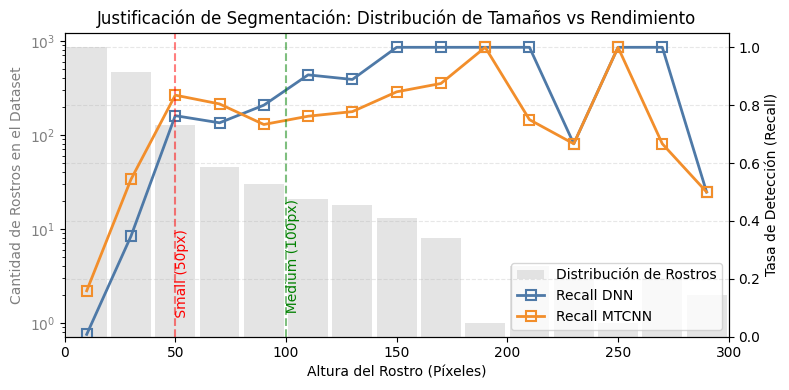

In [34]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# Eje Izquierdo (Histograma de Distribución)
color_bar = 'lightgray'
ax1.set_xlabel('Altura del Rostro (Píxeles)')
ax1.set_ylabel('Cantidad de Rostros en el Dataset', color='gray')
bars = ax1.bar(bin_centers, hist_counts, width=BIN_WIDTH*0.9, color=color_bar, alpha=0.6, label='Distribución de Rostros')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_yscale("log")
# Eje Derecho (Curvas de Recall)
ax2 = ax1.twinx()  # Instanciar un segundo eje que comparte el mismo eje x
ax2.set_ylabel('Tasa de Detección (Recall)', color='black')

# Graficar líneas
line1, = ax2.plot(bin_centers, recall_dnn, color='#4E79A7', marker='s', markersize=7, mfc="none",  \
                  mec ='#4E79A7',mew=1.5, linewidth=2, label='Recall DNN')
line2, = ax2.plot(bin_centers, recall_mtcnn, color='#F28E2B', marker='s', markersize=7, mfc="none",\
                  mec='#F28E2B',mew=1.5, linewidth=2, label='Recall MTCNN')

# segmentation (Small/Medium/Large)
plt.axvline(x=50, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=100, color='green', linestyle='--', alpha=0.5)

# Añadir etiquetas de texto a las líneas verticales
ax2.text(50, 0.05, ' Small (50px)', color='red', rotation=90, verticalalignment='bottom')
ax2.text(100, 0.05, '  Medium (100px)', color='green', rotation=90, verticalalignment='bottom')

# Configurar límites y leyenda
ax2.set_ylim(0, 1.05)
ax2.set_xlim(0, MAX_SIZE_PLOT)

# Combinar leyendas de ambos ejes
lines = [bars, line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right') #'upper center')

plt.title('Justificación de Segmentación: Distribución de Tamaños vs Rendimiento')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Examples/Category

In [ ]:
# representative examples/ images for each categiry
RANGES = {
    'Small (<50px)': (0, 50),
    'Medium (50-100px)': (50, 100),
    'Large (>100px)': (100, 9999)
}

# 'Category': [ (path_img1, box), (path_img2, box) ]
examples_found = {k: [] for k in RANGES.keys()}

def get_category_name(h):
    for name, (min_h, max_h) in RANGES.items():
        if min_h <= h < max_h:
            return name
    return None


collected = 0
needed=6
for img_path_rel, boxes in ground_truth.items():
    if collected >= needed: break # Ya tenemos todo
    
    for box in boxes:
        x, y, w, h = box
        cat = get_category_name(h)
        
        if cat and len(examples_found[cat]) < 2:
            examples_found[cat].append((img_path_rel, box))
            collected += 1
            break 


fig, axes = plt.subplots(3, 2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.4)

ordered_cats = ['Small (<50px)', 'Medium (50-100px)', 'Large (>100px)']

for row_idx, cat_name in enumerate(ordered_cats):
    samples = examples_found[cat_name]
    
    for col_idx, (img_path, box) in enumerate(samples):
        full_path = os.path.join(val_images, img_path)
        img = cv2.imread(full_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img, _ = img.shape
        x, y, w, h = box
        
        # face box
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # zoom in
        # to easily see the face
        pad_x = w
        pad_y = h
        
        # Coordenadas de recorte asegurando no salirnos de la imagen
        crop_x1 = max(0, x - pad_x)
        crop_y1 = max(0, y - pad_y)
        crop_x2 = min(w_img, x + w + pad_x)
        crop_y2 = min(h_img, y + h + pad_y)
        
        cropped_img = img[crop_y1:crop_y2, crop_x1:crop_x2]
        
        # Mostrar en el subplot correspondiente
        ax = axes[row_idx, col_idx]
        ax.imshow(cropped_img)
        ax.set_title(f"{cat_name}\nAltura Real: {h}px", fontsize=10)
        ax.axis('off')


#fig.suptitle("Comparativa Visual por Tamaño de Rostro (Ground Truth)\n(Recortes con Zoom)", fontsize=16)
plt.tight_layout()
plt.show()

## Pre-processing

In [47]:
CONF_THRESH_DNN   = 0.4   # Bajamos un poco para captar más caras difíciles (luego filtramos)
CONF_THRESH_MTCNN = 0.8 
IOU_THRESH        = 0.4
TARGET_SIZE_DNN   = (1024, 1024) # force to ingrease the img size

# --- light correction
def preprocess_image(img_bgr):
    # gamma correction
    gamma = 1.5 # for values greater than 1 -> makes img clearer
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img_gamma = cv2.LUT(img_bgr, table)
    
    # Sharpening to enhace borders
    kernel = np.array([[0, -1, 0], 
                       [-1, 5,-1], 
                       [0, -1, 0]])
    img_sharp = cv2.filter2D(img_gamma, -1, kernel)
    
    return img_sharp


stats_improved = {
    'DNN_Base':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}, # Para comparar
    'DNN_Mejorado': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

print("comparative")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Preparamos Ground Truth
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # =======================================================
    # 1. DNN BASE (Como lo tenías antes, para control)
    # =======================================================
    # Usaba tamaño original
    blob_base = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_base)
    det_base = net.forward()
    
    preds_base = []
    for i in range(det_base.shape[2]):
        if det_base[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_base[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_base.append(box.astype("int"))
            
    # =======================================================
    # 2. DNN MEJORADO (Gamma + High-Res Blob)
    # =======================================================
    
    # A. Aplicar mejora de luz
    img_opt = preprocess_image(img_bgr)
    
    # B. Upsampling en el Blob (Aquí ocurre la magia del tamaño)
    # Usamos TARGET_SIZE_DNN (1024x1024)
    # Nota: SSD redimensiona internamente, pero al darle un target grande, no pierde detalles.
    blob_opt = cv2.dnn.blobFromImage(img_opt, 1.0, TARGET_SIZE_DNN, (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_opt)
    det_opt = net.forward()
    
    preds_opt = []
    for i in range(det_opt.shape[2]):
        confidence = det_opt[0, 0, i, 2]
        if confidence > CONF_THRESH_DNN:
            # IMPORTANTE: OpenCV devuelve coordenadas normalizadas (0 a 1).
            # Al multiplicar por (w_orig, h_orig), automáticamente mapeamos 
            # de vuelta a la imagen original, sin importar que el blob fuera 1024x1024.
            box = det_opt[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_opt.append(box.astype("int"))

    # ==========================
    # EVALUACIÓN
    # ==========================
    evaluate_model_by_size('DNN_Base', preds_base, gt_boxes, gt_heights, stats_improved) 
    evaluate_model_by_size('DNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_improved)

# ... (Código de impresión de gráficas similar al anterior) ...

# IMPRIMIR TABLA COMPARATIVA TEXTO
print("\n--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_improved['DNN_Base'][cat]['TP']
    total = tp + stats_improved['DNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_improved['DNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_improved['DNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")

comparative
Procesando imagen 20...
Procesando imagen 40...
Procesando imagen 60...
Procesando imagen 80...
Procesando imagen 100...

--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---
Cat Small (<50px): 18.5% -> 19.0% (Mejora: +0.5%)
Cat Medium (50-100px): 79.0% -> 75.0% (Mejora: +-4.0%)
Cat Large (>100px): 78.9% -> 77.8% (Mejora: +-1.1%)


In [50]:
CONF_THRESH_DNN     = 0.4   # Bajamos un poco para captar más caras difíciles (luego filtramos)
CONF_THRESH_MTCNN   = 0.8 
IOU_THRESH          = 0.4
TARGET_SIZE_DNN     = (1024, 1024) # force to ingrease the img size
CONF_THRESH_STRICT  = 0.5  # Para medición estándar
CONF_THRESH_LENIENT = 0.3 # <--- CAMBIO 1: Ser más permisivo con caras difíciles
SCALE_FACTOR        = 2.0

# --- light correction
def preprocess_image(img_bgr):
    # gamma correction
    gamma = 1.5 # for values greater than 1 -> makes img clearer
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img_gamma = cv2.LUT(img_bgr, table)
    
    # Sharpening to enhace borders
    kernel = np.array([[0, -1, 0], 
                       [-1, 5,-1], 
                       [0, -1, 0]])
    img_sharp = cv2.filter2D(img_gamma, -1, kernel)
    
    return img_sharp


stats_improved = {
    'DNN_Base':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}, # Para comparar
    'DNN_Mejorado': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

print("comparative")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Preparamos Ground Truth
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # =======================================================
    # 1. DNN BASE (Como lo tenías antes, para control)
    # =======================================================
    # Usaba tamaño original
    blob_base = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_base)
    det_base = net.forward()
    
    preds_base = []
    for i in range(det_base.shape[2]):
        if det_base[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_base[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_base.append(box.astype("int"))
            
    # =======================================================
    # 2. DNN MEJORADO v2
    # =======================================================
    max_dim = max(w_orig, h_orig)
    if max_dim < 1200:
        scale = SCALE_FACTOR # x2.0
    else:
        scale = 1.0 # Dejar igual si ya es gigante
        
    new_w = int(w_orig * scale)
    new_h = int(h_orig * scale)
    
    # B. Aplicar preprocesamiento de luz (Gamma) - Mantenemos esto
    img_opt = preprocess_image(img_bgr) # Tu función gamma anterior
    
    # C. Crear Blob con tamaño dinámico proporcional
    blob_opt = cv2.dnn.blobFromImage(img_opt, 1.0, (new_w, new_h), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_opt)
    det_opt = net.forward()
    
    preds_opt = []
    for i in range(det_opt.shape[2]):
        confidence = det_opt[0, 0, i, 2]
        
        # Usamos el umbral más bajo (0.3) para captar lo que antes perdíamos
        if confidence > CONF_THRESH_LENIENT:
            # OpenCV maneja el re-escalado de coords automáticamente
            box = det_opt[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_opt.append(box.astype("int"))

    # ==========================
    # EVALUACIÓN
    # ==========================
    evaluate_model_by_size('DNN_Base', preds_base, gt_boxes, gt_heights, stats_improved) 
    evaluate_model_by_size('DNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_improved)

# ... (Código de impresión de gráficas similar al anterior) ...

# IMPRIMIR TABLA COMPARATIVA TEXTO
print("\n--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_improved['DNN_Base'][cat]['TP']
    total = tp + stats_improved['DNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_improved['DNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_improved['DNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")

comparative
Procesando imagen 20...
Procesando imagen 40...
Procesando imagen 60...
Procesando imagen 80...
Procesando imagen 100...

--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---
Cat Small (<50px): 18.5% -> 27.6% (Mejora: +9.1%)
Cat Medium (50-100px): 79.0% -> 75.8% (Mejora: +-3.2%)
Cat Large (>100px): 78.9% -> 58.9% (Mejora: +-20.0%)


In [52]:
# --- CONFIGURACIÓN ---
CONF_THRESH_LOW = 0.3    # Umbral permisivo para detectar caras difíciles
NMS_THRESH = 0.4         # Umbral para eliminar rectángulos duplicados superpuestos

def detectar_multiescala(net, img_bgr):
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Listas para acumular todas las detecciones de ambas escalas
    rects_totales = []
    confidencias_totales = []
    
    # ---------------------------------------------------------
    # ESCALA 1: ORIGINAL (Para caras Grandes y Medianas)
    # ---------------------------------------------------------
    # Usamos tamaño original (o limitado si es 4K para no explotar)
    blob1 = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob1)
    det1 = net.forward()
    
    for i in range(det1.shape[2]):
        conf = det1[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            box = det1[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            rects_totales.append(box.astype("int"))
            confidencias_totales.append(float(conf))

    # ---------------------------------------------------------
    # ESCALA 2: UPSCALING x2 (Para caras Pequeñas)
    # ---------------------------------------------------------
    # Aplicamos Gamma antes de escalar (tu mejora de luz)
    img_proc = preprocess_image(img_bgr) 
    
    # Escalamos x1.8 o x2.0 (Probemos 1.8 para no hacerlas tan gigantes)
    scale_factor = 1.8
    new_w, new_h = int(w_orig * scale_factor), int(h_orig * scale_factor)
    
    blob2 = cv2.dnn.blobFromImage(img_proc, 1.0, (new_w, new_h), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob2)
    det2 = net.forward()
    
    for i in range(det2.shape[2]):
        conf = det2[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            # Importante: Des-escalar las coordenadas para que coincidan con la original
            box = det2[0, 0, i, 3:7] * np.array([new_w, new_h, new_w, new_h])
            box = box / scale_factor # Volver a coordenadas originales
            rects_totales.append(box.astype("int"))
            confidencias_totales.append(float(conf))

    # ---------------------------------------------------------
    # FUSIÓN: NON-MAXIMUM SUPPRESSION (NMS)
    # ---------------------------------------------------------
    if len(rects_totales) > 0:
        # Convertir a formato [x, y, w, h] que requiere NMSBoxes
        boxes_nms = []
        for (x1, y1, x2, y2) in rects_totales:
            boxes_nms.append([x1, y1, x2 - x1, y2 - y1]) # x, y, ancho, alto
        
        # Aplicar NMS
        # Devuelve los índices de las cajas que SOBREVIVEN
        indices = cv2.dnn.NMSBoxes(boxes_nms, confidencias_totales, CONF_THRESH_LOW, NMS_THRESH)
        
        final_boxes = []
        # NMSBoxes devuelve una tupla de tuplas o lista aplanada dependiendo de la versión de OpenCV
        if len(indices) > 0:
            for i in indices.flatten():
                x, y, w, h = boxes_nms[i]
                final_boxes.append([x, y, x+w, y+h]) # Regresamos a x2, y2 para tu evaluador
        
        return final_boxes
    else:
        return []

def preprocess_image(img_bgr):
    # gamma correction
    gamma = 1.5 # for values greater than 1 -> makes img clearer
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img_gamma = cv2.LUT(img_bgr, table)
    
    # Sharpening to enhace borders
    kernel = np.array([[0, -1, 0], 
                       [-1, 5,-1], 
                       [0, -1, 0]])
    img_sharp = cv2.filter2D(img_gamma, -1, kernel)
    
    return img_sharp


stats_improved = {
    'DNN_Base':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}, # Para comparar
    'DNN_Mejorado': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

print("comparative")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Preparamos Ground Truth
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # =======================================================
    # 1. DNN BASE (Como lo tenías antes, para control)
    # =======================================================
    # Usaba tamaño original
    blob_base = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_base)
    det_base = net.forward()
    
    preds_base = []
    for i in range(det_base.shape[2]):
        if det_base[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_base[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_base.append(box.astype("int"))
            
    # =======================================================
    # 2. DNN MEJORADO v2
    # =======================================================
    # max_dim = max(w_orig, h_orig)
    # if max_dim < 1200:
    #     scale = SCALE_FACTOR # x2.0
    # else:
    #     scale = 1.0 # Dejar igual si ya es gigante
        
    # new_w = int(w_orig * scale)
    # new_h = int(h_orig * scale)
    
    # # B. Aplicar preprocesamiento de luz (Gamma) - Mantenemos esto
    # img_opt = preprocess_image(img_bgr) # Tu función gamma anterior
    
    # # C. Crear Blob con tamaño dinámico proporcional
    # blob_opt = cv2.dnn.blobFromImage(img_opt, 1.0, (new_w, new_h), (104.0, 117.0, 123.0), False, False)
    # net.setInput(blob_opt)
    # det_opt = net.forward()
    
    # preds_opt = []
    # for i in range(det_opt.shape[2]):
    #     confidence = det_opt[0, 0, i, 2]
        
    #     # Usamos el umbral más bajo (0.3) para captar lo que antes perdíamos
    #     if confidence > CONF_THRESH_LENIENT:
    #         # OpenCV maneja el re-escalado de coords automáticamente
    #         box = det_opt[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
    #         preds_opt.append(box.astype("int"))




    # =======================================================
    # 2. DNN MEJORADO (Multi-Escala)
    # =======================================================
    preds_opt = detectar_multiescala(net, img_bgr)

    # Evaluación
    evaluate_model_by_size('DNN_Base', preds_base, gt_boxes, gt_heights, stats_improved)
    evaluate_model_by_size('DNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_improved)

# ... Resto del código de impresión igual ...

comparative
Procesando imagen 20...
Procesando imagen 40...
Procesando imagen 60...
Procesando imagen 80...
Procesando imagen 100...


In [53]:
# IMPRIMIR TABLA COMPARATIVA TEXTO
print("\n--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_improved['DNN_Base'][cat]['TP']
    total = tp + stats_improved['DNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_improved['DNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_improved['DNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")


--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---
Cat Small (<50px): 18.5% -> 30.1% (Mejora: +11.6%)
Cat Medium (50-100px): 79.0% -> 84.7% (Mejora: +5.6%)
Cat Large (>100px): 78.9% -> 81.1% (Mejora: +2.2%)
